In [154]:
# Load data and modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier

df_base = pd.read_csv('train.csv') 

print(df_base.describe())
df_base.head()

                   X              Y
count  878049.000000  878049.000000
mean     -122.422616      37.771020
std         0.030354       0.456893
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416420      37.775421
75%      -122.406959      37.784369
max      -120.500000      90.000000


Dates        Category                      Descript   
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST  \
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address   
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST  \
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

[Text(0, 0, 'LARCENY/THEFT'),
 Text(1, 0, 'OTHER OFFENSES'),
 Text(2, 0, 'NON-CRIMINAL'),
 Text(3, 0, 'ASSAULT'),
 Text(4, 0, 'DRUG/NARCOTIC'),
 Text(5, 0, 'VEHICLE THEFT'),
 Text(6, 0, 'VANDALISM'),
 Text(7, 0, 'WARRANTS'),
 Text(8, 0, 'BURGLARY'),
 Text(9, 0, 'SUSPICIOUS OCC'),
 Text(10, 0, 'MISSING PERSON'),
 Text(11, 0, 'ROBBERY'),
 Text(12, 0, 'FRAUD'),
 Text(13, 0, 'FORGERY/COUNTERFEITING'),
 Text(14, 0, 'SECONDARY CODES'),
 Text(15, 0, 'WEAPON LAWS'),
 Text(16, 0, 'PROSTITUTION'),
 Text(17, 0, 'TRESPASS'),
 Text(18, 0, 'STOLEN PROPERTY'),
 Text(19, 0, 'SEX OFFENSES FORCIBLE'),
 Text(20, 0, 'DISORDERLY CONDUCT'),
 Text(21, 0, 'DRUNKENNESS'),
 Text(22, 0, 'RECOVERED VEHICLE'),
 Text(23, 0, 'KIDNAPPING'),
 Text(24, 0, 'DRIVING UNDER THE INFLUENCE'),
 Text(25, 0, 'RUNAWAY'),
 Text(26, 0, 'LIQUOR LAWS'),
 Text(27, 0, 'ARSON'),
 Text(28, 0, 'LOITERING'),
 Text(29, 0, 'EMBEZZLEMENT'),
 Text(30, 0, 'SUICIDE'),
 Text(31, 0, 'FAMILY OFFENSES'),
 Text(32, 0, 'BAD CHECKS'),
 Text(33, 0, 'BR

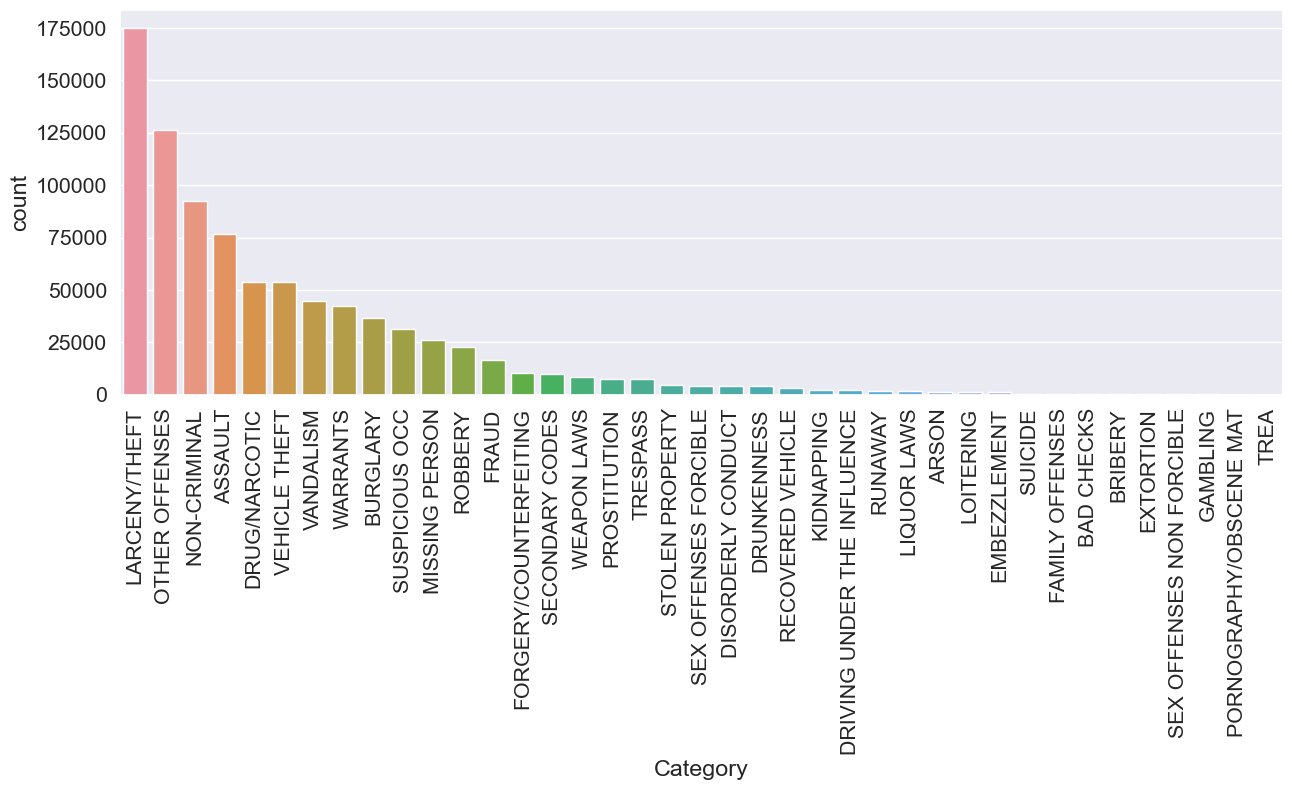

In [155]:
# Shows frequency of categories of crimes to help understand our data
plt.figure(figsize=(15,5))
ax = sns.countplot(x = df_base['Category'], orient='v', order = df_base['Category'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_35692\135401592.py:4: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0.0, 0, '0'),
 Text(25000.0, 0, '25000'),
 Text(50000.0, 0, '50000'),
 Text(75000.0, 0, '75000'),
 Text(100000.0, 0, '100000'),
 Text(125000.0, 0, '125000'),
 Text(150000.0, 0, '150000')]

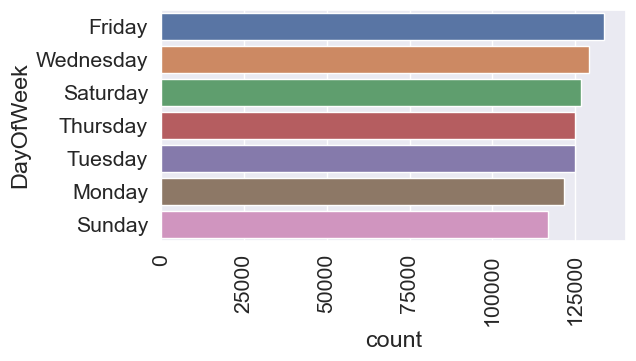

In [156]:
# Print crime counts per weekday to also help us understand our data
plt.figure(figsize=(6,3))
ax = sns.countplot(y = df_base['DayOfWeek'], orient='v', order = df_base['DayOfWeek'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

<Figure size 1600x1000 with 0 Axes>

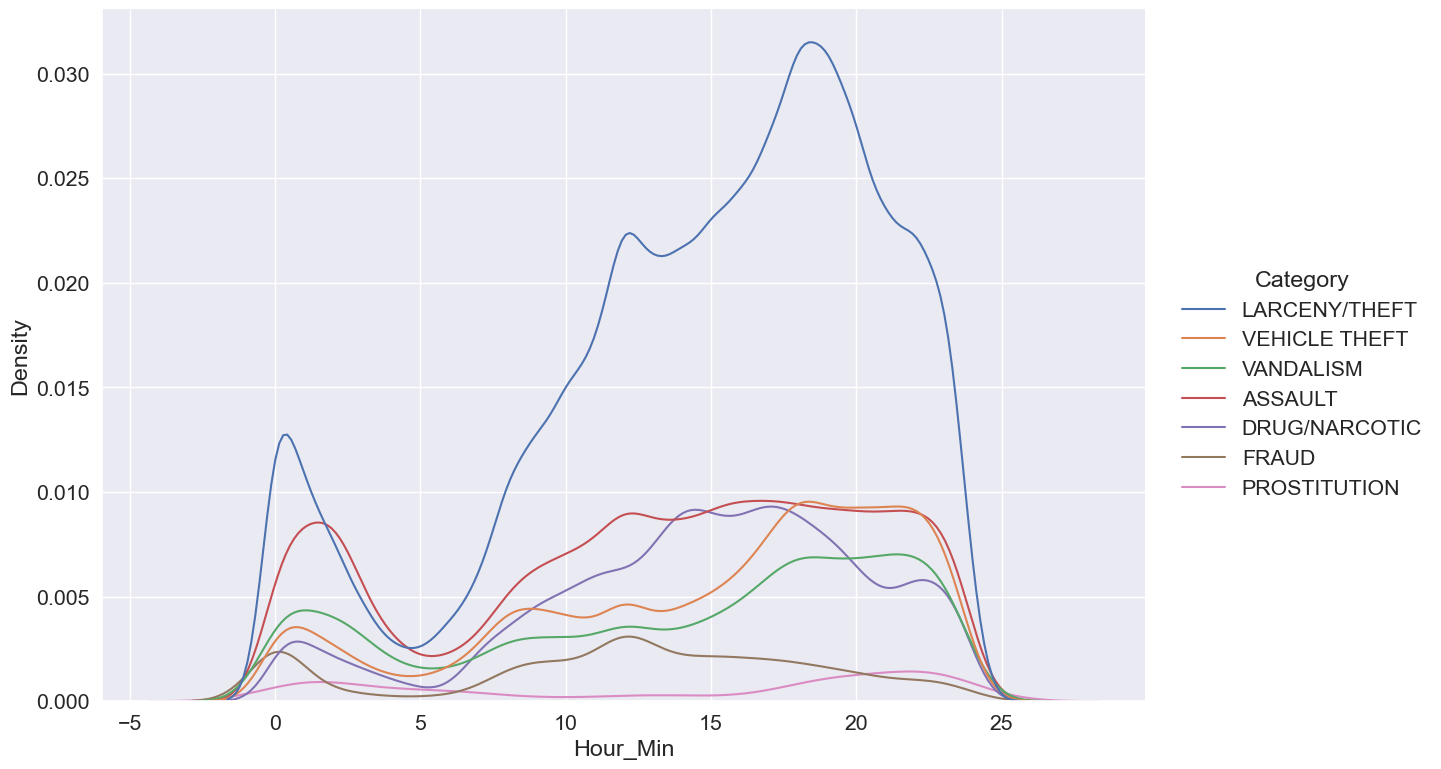

In [157]:
# Convert the time to minutes
df_base['Hour_Min'] = pd.to_datetime(df_base['Dates']).dt.hour  + pd.to_datetime(df_base['Dates']).dt.minute / 60
df_base['Hour'] = pd.to_datetime(df_base['Dates']).dt.hour

# Print crime counts per time and category to get overview of when the crimes were comitted
df_base_filtered = df_base[df_base['Category'].isin([
    'PROSTITUTION', 
    'VEHICLE THEFT', 
    'DRUG/NARCOTIC', 
    'WARRENTS', 
    'BURGLERY', 
    'FRAUD', 
    'ASSAULT',
    'LARCENY/THEFT',
    'VANDALISM'])]

plt.figure(figsize=(16,10))
ax = sns.displot(x = 'Hour_Min', hue="Category", data = df_base_filtered, kind="kde", height=8, aspect=1.5)

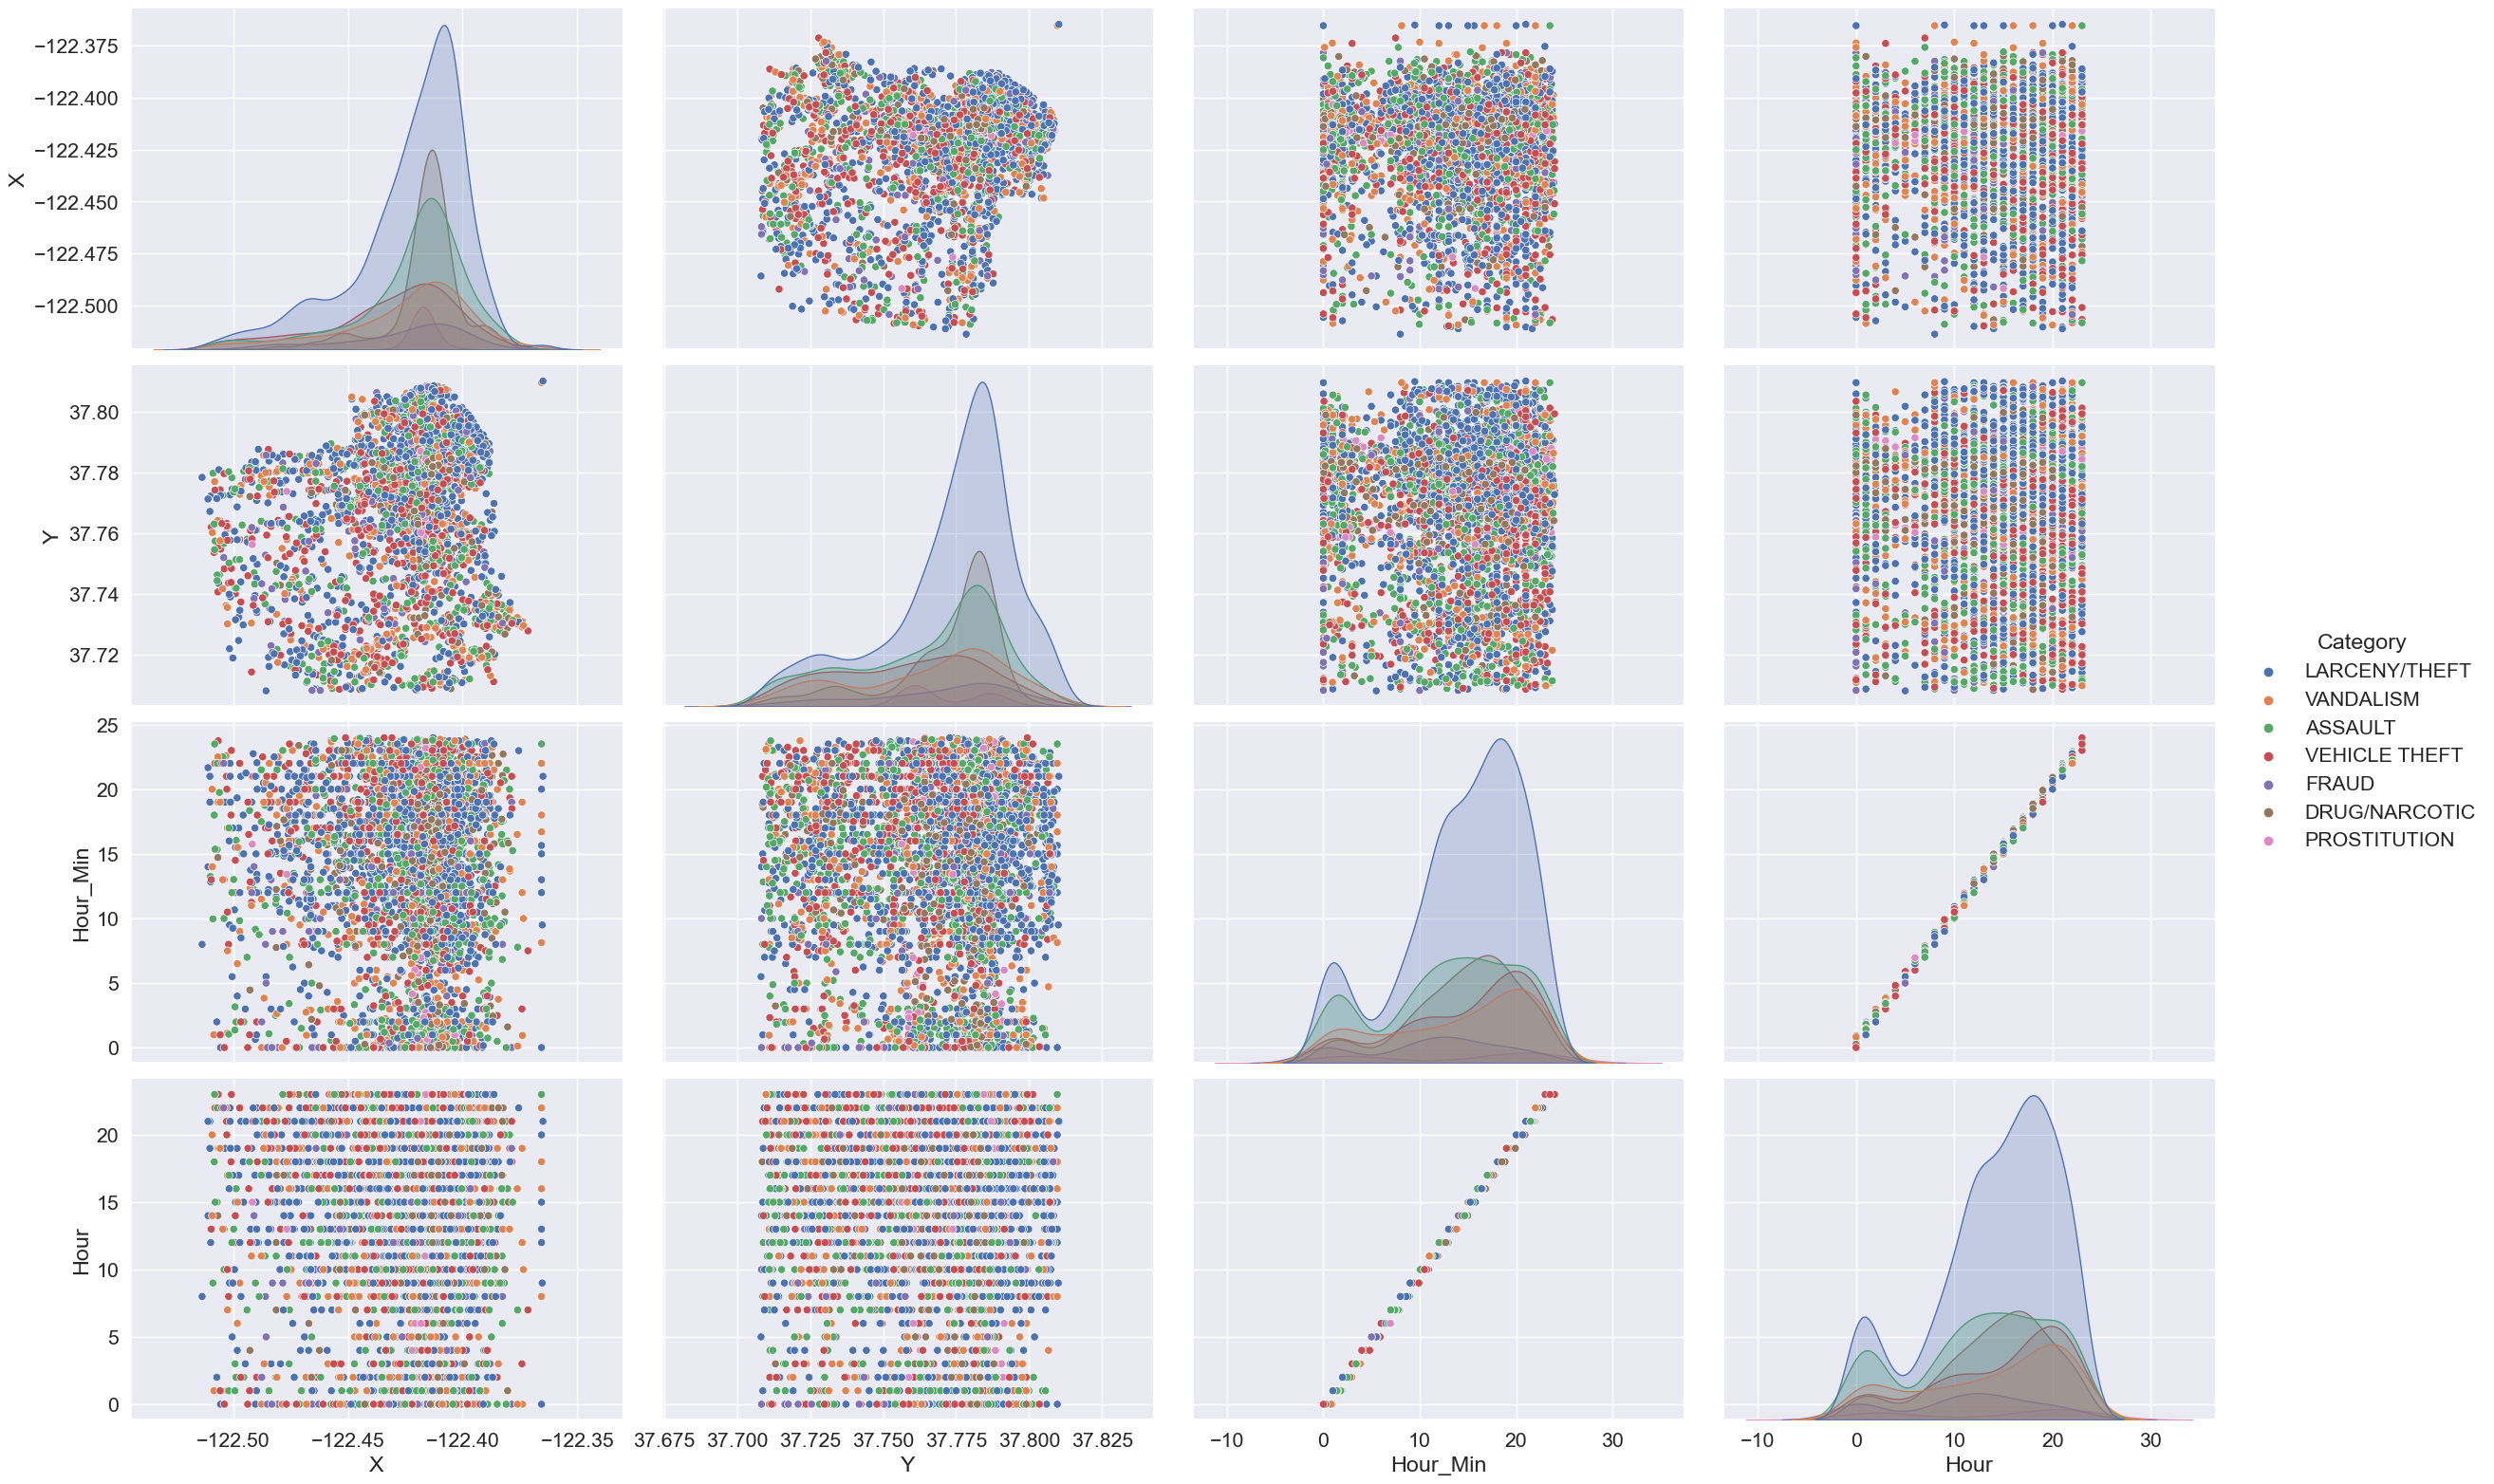

In [158]:
# Plot 1/100th of the data to reduce computation time and overview of other additional features
sns.pairplot(data = df_base_filtered[0::100], height=4, aspect=1.5, hue='Category')

In [159]:
# Extracting 10 sample values of crime addresses.. this helps us understand that a lot of crimes happened at intersections
for i in df_base['Address'][0:10]:
    print(i)

OAK ST / LAGUNA ST
OAK ST / LAGUNA ST
VANNESS AV / GREENWICH ST
1500 Block of LOMBARD ST
100 Block of BRODERICK ST
0 Block of TEDDY AV
AVALON AV / PERU AV
KIRKWOOD AV / DONAHUE ST
600 Block of 47TH AV
JEFFERSON ST / LEAVENWORTH ST


In [160]:
# In this section we create 3 features based on the information we learned in the above sections. Date & Time, Address and Latitude & Longitude. These features are comprised of different parts of our dataset to give a clear picture of when and where a crime occured
# Processing Function for Features
def cart2polar(x, y):
    dist = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return dist, phi

def preprocessFeatures(dfx):
    
    # Time Feature Engineering
    df = pd.get_dummies(dfx[['DayOfWeek' , 'PdDistrict']])
    df['Hour_Min'] = pd.to_datetime(dfx['Dates']).dt.hour + pd.to_datetime(dfx['Dates']).dt.minute / 60
    df['Hour'] = pd.to_datetime(dfx['Dates']).dt.hour
    # We add a feature that contains the expontential time
    df['Hour_Min_Exp'] = np.exp(df['Hour_Min'])
    
    df['Day'] = pd.to_datetime(dfx['Dates']).dt.day
    df['Month'] = pd.to_datetime(dfx['Dates']).dt.month
    df['Year'] = pd.to_datetime(dfx['Dates']).dt.year

    month_one_hot_encoded = pd.get_dummies(pd.to_datetime(dfx['Dates']).dt.month, prefix='Month')
    df = pd.concat([df, month_one_hot_encoded], axis=1, join="inner")
    
    # Convert Carthesian Coordinates to Polar Coordinates
    df[['X', 'Y']] = dfx[['X', 'Y']] # we maintain the original coordindates as additional features
    df['dist'], df['phi'] = cart2polar(dfx['X'], dfx['Y'])
  
    # Extracting Street Types
    df['Is_ST'] = dfx['Address'].str.contains(" ST", case=True)
    df['Is_AV'] = dfx['Address'].str.contains(" AV", case=True)
    df['Is_WY'] = dfx['Address'].str.contains(" WY", case=True)
    df['Is_TR'] = dfx['Address'].str.contains(" TR", case=True)
    df['Is_DR'] = dfx['Address'].str.contains(" DR", case=True)
    df['Is_Block'] = dfx['Address'].str.contains(" Block", case=True)
    df['Is_crossing'] = dfx['Address'].str.contains(" / ", case=True)
    
    return df

# Processing Function for Labels
def encodeLabels(dfx):
    df = pd.DataFrame (columns = [])
    factor = pd.factorize(dfx['Category'])
    return factor

# Remove Outliers by Longitude
df_cleaned = df_base[df_base['Y']<70]

# Encode Labels as Integer
factor = encodeLabels(df_cleaned)
y_df = factor[0]
labels = list(factor[1])
# for val, i in enumerate(labels):
#     print(val, i)

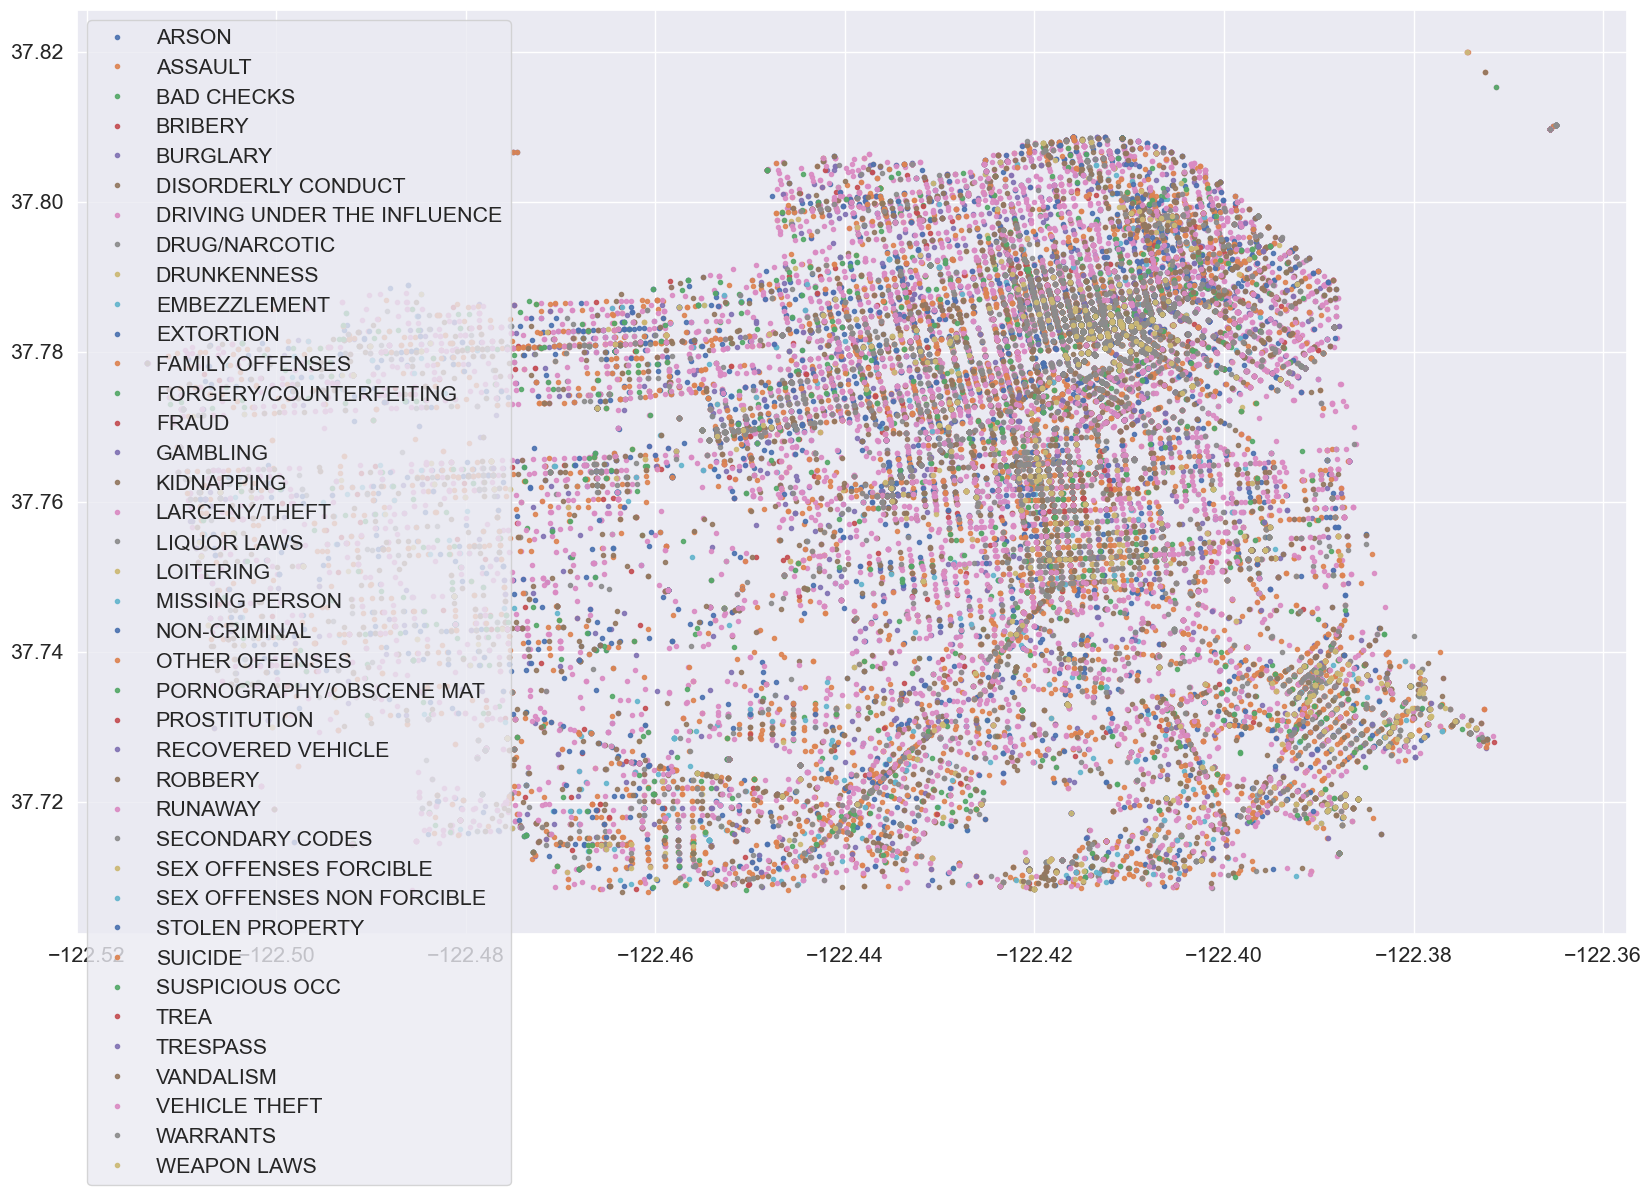

In [161]:
# Scatter plot of crimes across San Fransisco, which helps us see if certain crimes happen a lot in certain areas
# Plot Criminal Activities by Lat and Long
df_filtered = df_cleaned.sample(frac=0.05)  
#df_filtered = df_cleaned[df_cleaned['Category'].isin(['PROSTITUTION', 'VEHICLE THEFT', 'FRAUD'])].sample(frac=0.05) # to filter 

groups = df_filtered.groupby('Category')

fig, ax = plt.subplots(sharex=False, figsize=(20, 12))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['X'], group['Y'], marker='.', linestyle='', label=name, alpha=0.9)
ax.legend()
plt.show()

In [162]:
# 4.2 Create a Crime Map of San Francisco using Plotly
# Limit the data to a fraction and selected categories
df_filtered = df_cleaned.sample(frac=0.01) 
fig = px.scatter_mapbox(df_filtered, lat="Y", lon="X", hover_name="Category", color='Category', hover_data=["Y", "X"], zoom=12, height=800)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [163]:
# Create train_df & test_df
x_df = preprocessFeatures(df_cleaned).copy()

# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.7, random_state=0)
x_train

DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday   
276998             False             False               False  \
81579              False             False               False   
206676             False             False               False   
732006             False             False               False   
796194              True             False               False   
...                  ...               ...                 ...   
359783             False              True               False   
152315             False             False               False   
117952             False             False               False   
435829             False             False               False   
305711             False             False                True   

        DayOfWeek_Sunday  DayOfWeek_Thursday  DayOfWeek_Tuesday   
276998             False               False               True  \
81579              False               False               True   
206676              True               False              False   
732006             False               False              False   
796194             False               False              False   
...                  ...                 ...                ...   
359783             False               False              False   
152315              True               False              False   
117952             False               False               True   
435829              True               False              False   
305711             False               False              False   

        DayOfWeek_Wednesday  PdDistrict_BAYVIEW  PdDistrict_CENTRAL   
276998                False               False               False  \
81579                 False               False               False   
206676                False               False               False   
732006                 True               False               False   
796194                False               False               False   
...                     ...                 ...                 ...   
359783                False               False               False   
152315                False               False               False   
117952                False               False               False   
435829                False               False               False   
305711                False                True               False   

        PdDistrict_INGLESIDE  ...          Y        dist       phi  Is_ST   
276998                 False  ...  37.785023  128.110900  2.842200   True  \
81579                  False  ...  37.748470  128.185052  2.842677  False   
206676                 False  ...  37.762744  128.113657  2.842389   True   
732006                 False  ...  37.784140  128.109653  2.842204   True   
796194                 False  ...  37.791333  128.125982  2.842185   True   
...                      ...  ...        ...         ...       ...    ...   
359783                 False  ...  37.785745  128.105231  2.842180   True   
152315                 False  ...  37.783386  128.108378  2.842207   True   
117952                 False  ...  37.783053  128.109942  2.842214   True   
435829                 False  ...  37.786565  128.106822  2.842178   True   
305711                 False  ...  37.719183  128.067080  2.842632   True   

        Is_AV  Is_WY  Is_TR  Is_DR  Is_Block  Is_crossing  
276998  False  False  False  False      True        False  
81579    True  False  False  False      True        False  
206676  False  False  False  False      True        False  
732006  False  False  False  False     False         True  
796194  False  False  False  False      True        False  
...       ...    ...    ...    ...       ...          ...  
359783  False  False  False  False     False         True  
152315  False  False  False  False      True        False  
117952  False  False  False  False      True        False  
435829  False  False  False  Fal

In [164]:
addresses = df_base['Address'].unique()
binary_dict = {address: i for i, address in enumerate(addresses)}
filtered_address_df = df_base['Address_Binary'] = df_base['Address'].map(binary_dict)


columns_to_drop = ['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'X', 'Y', "Hour_Min", "Address"]
filtered_columns = df_base.drop(columns_to_drop, axis=1)

# df = pd.DataFrame(np.arange(12).reshape(3, 4),
#                   columns=['A', 'B', 'C', 'D'])
filtered_columns.head()

Hour  Address_Binary
0    23               0
1    23               0
2    23               1
3    23               2
4    23               3

In [167]:
x = filtered_columns  # Features
y = df_base["Hour"]# Features

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.25, random_state=0)

clf = DecisionTreeClassifier(max_depth=10, random_state=0)

# Fit the model to the training data
clf.fit(x_train, y_train)

# Predict on the test data
y_pred = clf.predict(x_test)


# Evaluate the performance of the model
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33620
           1       0.00      0.00      0.00     19593
           2       0.00      0.00      0.00     16677
           3       0.00      0.00      0.00     10476
           4       0.00      0.00      0.00      7416
           5       0.00      0.00      0.00      6473
           6       0.00      0.00      0.00      9896
           7       0.00      0.00      0.00     16652
           8       0.22      1.00      0.36     24754
           9       1.00      1.00      1.00     26633
          10       1.00      1.00      1.00     28453
          11       1.00      1.00      1.00     28728
          12       1.00      1.00      1.00     39008
          13       1.00      1.00      1.00     32347
          14       1.00      1.00      1.00     33336
          15       1.00      1.00      1.00     36043
          16       1.00      1.00      1.00     37596
          17       1.00    

In [166]:
# Train a single random forest classifier - parameters are a best guess
# We will use this algorithm as a baseline to test against our gradient boost
clf = RandomForestClassifier(max_depth=100, random_state=0, n_estimators = 200, )
clf.fit(x_train, y_train.ravel())
y_pred = clf.predict(x_test)

results_log = classification_report(y_test, y_pred, zero_division=0)
print(results_log)

KeyboardInterrupt: 

In [ ]:
# Configure the XGBoost model
param = {'booster': 'gbtree', 
         'tree_method': 'gpu_hist',
         'predictor': 'gpu_predictor',
         'max_depth': 140, 
         'eta': 0.3, 
         'objective': '{multi:softmax}', 
         'eval_metric': 'mlogloss', 
         'num_round': 30,
         'feature_selector ': 'cyclic'
        }

xgb_clf = XGBClassifier(param)
xgb_clf.fit(x_train, y_train.ravel())
score = xgb_clf.score(x_test, y_test.ravel())
print(score)

# Create predictions on the test dataset
y_pred = xgb_clf.predict(x_test)

# Print a classification report
results_log = classification_report(y_test, y_pred)
print(results_log)

In [ ]:
# Print a multi-Class Confusion Matrix
cnf_matrix = confusion_matrix(y_test.reshape(-1), y_pred)
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (16,12))
plt.tight_layout()
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, cbar=True, cmap= "inferno", annot=False, fmt='.0f' #, annot_kws={"size": 13}
           )

In [ ]:
# Our confusion matrix shows us that our model frequently predicts crime category two abnd neglects the other types of crime. The reason is the uneven distribution of crime types in the training data.

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn import cluster

# Select the relevant features for clustering
features = ['X', 'Y']  # Update with the column names representing latitude and longitude

# Fit the clustering model
model = cluster.KMeans(init="k-means++", n_clusters=16)
model.fit_predict(df_filtered[features])

# Add the cluster labels to the DataFrame
df_filtered['Cluster'] = model.labels_

# Define a color mapping for the categories
category_color_map = {category: color for category, color in zip(df_filtered['Category'].unique(), px.colors.qualitative.Set1)}

# Map the categories to colors
df_filtered['CategoryColor'] = df_filtered['Category'].map(category_color_map)

# Visualize the clusters on a map with colors based on categories
fig = px.scatter_mapbox(df_filtered, lat='Y', lon='X', color='Cluster', hover_data=['Cluster', 'Category'], zoom=10)
fig.update_layout(mapbox_style='open-street-map')
fig.show()
